<a href="https://colab.research.google.com/github/Leinadh/PeruvianImageGenerator/blob/master/face_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !tar -zxvf '/content/drive/My Drive/Made with ML/datasets/vgg_face_dataset.tar.gz'

# Image Preprocessing

In [17]:
!rm -r PeruvianImageGenerator/ # to delete file cloned before

In [18]:
!git clone https://github.com/Leinadh/PeruvianImageGenerator.git

Cloning into 'PeruvianImageGenerator'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14406 (delta 5), reused 10 (delta 3), pack-reused 14391
Receiving objects: 100% (14406/14406), 595.16 MiB | 29.54 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (14324/14324), done.


In [27]:
# !cd PeruvianImageGenerator/; git pull

Already up to date.


In [31]:
import PeruvianImageGenerator.scripts.download_faces as dlf
import PeruvianImageGenerator.scripts.plot_utils as plot_utils

In [7]:
data_path = '/content/PeruvianImageGenerator/datasets/face_datasets/vgg_face_dataset/files'
target_path='/content/tmp/face_images/'

dlf.download_vgg_images(data_path, num_people=2622, num_images=1, target_path=target_path,
                        offset_x_percent=33, offset_top_percent=70,
                        offset_bottom_percent=20, min_pose=3, min_score=0,
                        curation=False, formats_allowed=['jpg', 'jpeg'], from_notebook=True)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [8]:
dlf.clean_corrupt_files(target_path, formats_allowed=['jpg', 'jpeg'])

Removing corrupt file: Fred_Astaire_1.jpg
Removing corrupt file: Jane_Campion_1.jpg
Removing corrupt file: Marcello_Mastroianni_1.jpg
Removing corrupt file: Alan_Tudyk_1.jpg
Removing corrupt file: Claude_Rains_1.jpg
Removing corrupt file: Ty_Olsson_1.jpg
Removing corrupt file: Andy_Richter_1.jpg
Removing corrupt file: Marlene_Dietrich_1.jpg
Removing corrupt file: Adam_Rodriguez_1.jpg
Removing corrupt file: Seth_Green_1.jpg
Removing corrupt file: Alexander_Siddig_1.jpg
Removing corrupt file: Abel_Ferrara_1.jpg
Removing corrupt file: Lee_Marvin_1.jpg
Removing corrupt file: Grace_Zabriskie_1.jpg
Removing corrupt file: Dwight_Schultz_1.jpg
Removing corrupt file: Jim_Sturgess_1.jpg
Removing corrupt file: Sal_Mineo_1.jpg
Removing corrupt file: Suzanne_Pleshette_1.jpg
Removing corrupt file: Christina_Moore_1.jpg
Removing corrupt file: John_Amos_1.jpg
Removing corrupt file: James_Stewart_1.jpg
Removing corrupt file: Myrna_Loy_1.jpg
Removing corrupt file: Gloria_Reuben_1.jpg
Removing corrupt fi

In [9]:
# !zip -r -q /content/face_images.zip tmp/face_images

# Image Segmentation

In [13]:
# !pip install keras-segmentation

In [15]:
import numpy as np
from PIL import Image
import os

## Show random image

Janina_Gavankar_1.jpg


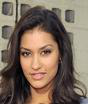

In [94]:
path = '/content/tmp/face_images/'
random_img = np.random.choice(os.listdir(path))
print(random_img)
Image.open(path + '/' + random_img)

## Remove background

In [40]:
import PeruvianImageGenerator.scripts.download_faces as dlf

In [41]:
images_path = '/content/tmp/face_images/'
masks_path = '/content/tmp/masks/'
output_path = '/content/face_images_wo_bg/'

dlf.remove_background(images_path, masks_path, output_path, from_notebook=True)



f



Background removed
Processing time: 20.31 min



In [42]:
!zip -r -q /content/face_images_wo_bg.zip face_images_wo_bg

In [43]:
!cp -r /content/face_images_wo_bg.zip "/content/drive/My Drive/Made with ML/datasets/face_images_wo_bg-10-08-2020.zip" #copy to